In [1]:
import rasterio
import numpy as np
import geopandas as gpd
import subprocess

from matplotlib import pyplot

from rasterio.merge import merge
from rasterio.crs import CRS
from rasterio.warp import transform_geom
import rasterio.mask

from shapely.geometry import shape, mapping, Polygon, MultiPolygon
from descartes import PolygonPatch

## Read Shapefile

In [2]:
cambodia_waterbodies_path = 'water-bodies-09-08-2016'
df = gpd.read_file(cambodia_waterbodies_path)
tonlesap = df[df.name == 'Boeung Tonle Sap']

## Mask GeoTiff Data

In [3]:
dataset = '201712'
src_ndvi = rasterio.open('MERGED/' + dataset + '/NDVI.TIF')
src_ndwi = rasterio.open('MERGED/' + dataset + '/NDWI.TIF')
src_ndwi2 = rasterio.open('MERGED/' + dataset + '/NDWI2.TIF')
trans = src_ndvi.transform

/home/ahldt/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
tonlesap_shape = tonlesap.geometry.values[0]
tonlesap_geom = mapping(tonlesap_shape)
tonlesap_shape = [transform_geom(df.crs, src_ndvi.crs, tonlesap_geom)]

Create new shape to mask : Rectangle ~

In [5]:
inf = float("inf")
x0, y0, x1, y1 = [inf, -inf, -inf, inf] #top-left, bottom-right
for x, y in tonlesap_shape[0]['coordinates'][0]:
    if x0 > x:
        x0 = x
    if x1 < x:
        x1 = x
    if y0 < y:
        y0 = y
    if y1 > y:
        y1 = y
new_coordinates = [{'type': 'Polygon', 'coordinates': [[(x0-1000, y0+1000),(x1+1000, y0+1000), 
                                                        (x1+1000, y1-1000), (x0-1000, y1-1000)]]}]
ndvi, _ = rasterio.mask.mask(src_ndvi, new_coordinates, crop=True)
ndwi, _ = rasterio.mask.mask(src_ndwi, new_coordinates, crop=True)
ndwi2, _ = rasterio.mask.mask(src_ndwi2, new_coordinates, crop=True)

In [6]:
new_ndvi = np.zeros(ndvi.shape)
m = ndvi.shape[1]
n = ndvi.shape[2]
for i in range(m):
    for j in range(n):
        val = ndvi[0,i,j]
        new_ndvi[0,i,j] = val if val < 0 else 1

In [7]:
new_ndwi2 = np.zeros(ndwi2.shape)
m = ndwi2.shape[1]
n = ndwi2.shape[2]
for i in range(m):
    for j in range(n):
        val = ndwi2[0,i,j]
        new_ndwi2[0,i,j] = val if val > 0 else -1

In [8]:
new_ndwi = np.zeros(ndwi.shape)
m = ndwi.shape[1]
n = ndwi.shape[2]
for i in range(m):
    for j in range(n):
        val = ndwi[0,i,j]
        new_ndwi[0,i,j] = val if val > 0 else -1

## Expansion using BFS-methods

In [9]:
def insideMatrix(x, y, m, n):
    if x < 0 or x >= m or y < 0 or y >= n:
        return False
    return True

Function for expansion

In [10]:
def check_expansion(val, type_of_map):
    if (type_of_map == 'NDVI'):
        if (val < 0):
            return True;
        return False;
    if (type_of_map == 'NDWI'):
        if (val > 0):
            return True;
        return False;
    if (type_of_map == 'NDWI2'):
        if (val > 0):
            return True;
        return False;  
    return null;

Count pixel depends on type of Map:

In [11]:
def count_pixel(obj, type_of_map, startingPoint):
    from queue import Queue
    dx = [0,1,0,-1]
    dy = [1,0,-1,0]

    visited = np.zeros((obj.shape[1], obj.shape[2])).astype('bool')
    final_obj= np.zeros((obj.shape[1], obj.shape[2]))

    u0, v0 = startingPoint[0], startingPoint[1]

    q = Queue()
    q.put((u0, v0))
    visited[u0, v0] = True
    countPixel = 0

    while not q.empty():
        u, v = q.get()
        final_obj[u, v] = -1
        countPixel += 1
        for k in range(4):
            _u, _v = u + dx[k], v + dy[k]
            if not insideMatrix(_u, _v, obj.shape[1], obj.shape[2]): 
                continue
            if check_expansion(obj[0, _u, _v], type_of_map) and not visited[_u, _v]:
                visited[_u, _v] = True
                q.put((_u, _v))
    pyplot.imshow(final_obj)
    return countPixel

In [12]:
dataset

'201712'

2864.0592

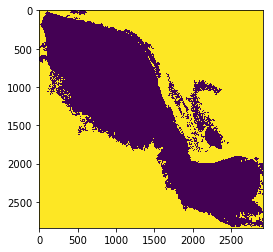

In [13]:
count_pixel(ndvi, 'NDVI', [1000, 1000]) * 900 / 1000000

3035.4471

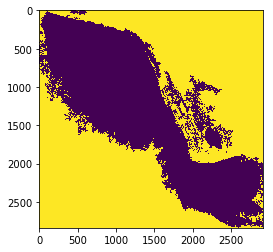

In [14]:
count_pixel(ndwi, 'NDWI', [1000, 1000]) * 900 / 1000000

3772.2852

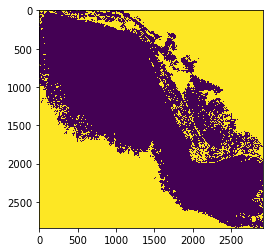

In [15]:
count_pixel(ndwi2, 'NDWI2', [1000, 1000]) * 900 / 1000000

## Data Calculated

In [17]:
data_collected = [
    {
        'dataset': '201612',
        'ndvi': 2455.1217,
        'ndwi': 2576.6064,
        'ndwi2': 2749.0653
    },
    {
        'dataset': '201701',
        'ndvi': 2492.3394,
        'ndwi': 2723.6862,
        'ndwi2': 3083.7717
    },
    {
        'dataset': '201702',
        'ndvi': 2455.1217,
        'ndwi': 2576.6064,
        'ndwi2': 2749.0653
    },
    {
        'dataset': '201703',
        'ndvi': 2256.5034,
        'ndwi': 2136.7512,
        'ndwi2': 2779.1991
    },
    {
        'dataset': '201704',
        'ndvi': 1642.392,
        'ndwi': 0.0009,
        'ndwi2': 2454.0516
    },
    {
        'dataset': '201705',
        'ndvi': 1257.3747,
        'ndwi': 472.7358,
        'ndwi2': 2551.2696
    },
    {
        'dataset': '201706',
        'ndvi': 1543.4145,
        'ndwi': 943.8552,
        'ndwi2': 3012.9354
    },
    {
        'dataset': '201707',
        'ndvi': 2387.547,
        'ndwi': 2291.1777,
        'ndwi2': 3294.4464
    },
    {
        'dataset': '201708',
        'ndvi': 2601.6435,
        'ndwi': 2730.7782,
        'ndwi2': 4749.1713
    },
    {
        'dataset': '201709',
        'ndvi': 1046.772,
        'ndwi': 1913.9562,
        'ndwi2': 5407.8867
    },
    {
        'dataset': '201710',
        'ndvi': 2354.175,
        'ndwi': 2656.8711,
        'ndwi2': 5391.6444
    },
    {
        'dataset': '201711',
        'ndvi': 2480.7996,
        'ndwi': 2649.7107,
        'ndwi2': 6477.8256
    },
    {
        'dataset': '201712',
        'ndvi': 2864.0592,
        'ndwi': 3035.4471,
        'ndwi2': 3772.2852
    }
]

Get each array

In [21]:
ndvi_set = [x['ndvi'] for x in data_collected]
ndwi_set = [x['ndwi'] for x in data_collected]
ndwi2_set = [x['ndwi2'] for x in data_collected]

Simulating result

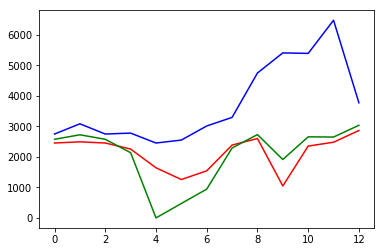

In [22]:
pyplot.plot(ndvi_set, 'r')
pyplot.plot(ndwi_set, 'g')
pyplot.plot(ndwi2_set, 'b')
pyplot.show()

Data floodobervartory

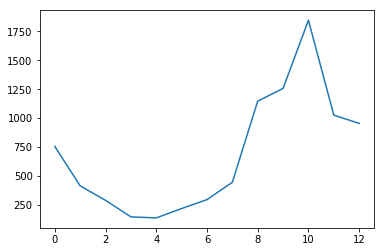

In [23]:
flood_data = [756, 415, 290, 147, 138, 219, 296, 446, 1147, 1257, 1846, 1026, 955]
pyplot.plot(flood_data)
pyplot.show()